## Versione 15.0

### Setup generale & Aggiornamenti
- **Dimensione**           : 2D
- **Traiettorie**          : abilitate nel codice separato "test_AnimFromData_v2.ipynb"
- **Tempi esecuzione**     : ridurre frames_per_year per simulazioni sopra i 10y
- **Visualizzazione**      : pianeti interni ed esterni separabili per ottimizzare grafica
- **Calcolo accelerazione**: gravità di tutti i pianeti e del Sole
- **Propagatori**          : Verlet, Runge-Kutta, Leapfrog (prestazioni simili a Verlet)
- **Sfondo e margini**     : nero, adattabili alla distanza maggiore con supplemento del 20%
- **Elementi grafici**     : pianeti colorati, legenda ON, anno corrente ON
- **Ordine codice**        : divisione in Sezioni
- **Grafici dell'Energia** : generale, divisi per PE/KE/ME
- **Tempo esecuzione**     : eliminato 
- **Salvataggio posizioni** : su file, per spezzare calcolo e animazione -> implementato in 'test_AnimFromData_v2.ipynb'

### Aggiornamenti possibili
- **Dimensione aggiuntiva** : 3D
- **Grafici aggiuntivi**    : x(t), y(t) per ogni pianeta
- **Tempi esecuzione**      : modificare per ottenere 1_000_000 anni

### READ ME BEFORE LAUNCH

- **NOTA BENE**             : non rieseguire la stampa su file più volte con stessi parametri altrimenti sovrascrive!
- **DIVERGENZA MERCURIO**   : per non fare divergere Mercurio bisogna usare un timestep basso essendo il suo periodo di circa 88gg 
- **TXT & ANIMAZIONE**      : questo codice genera i file txt con le posizioni dei pianeti selezionati, per completare l'animazione lanciare "test_AnimFromData.ipyb" modificando "label_names" e il nome del salvataggio dell'animazione prima di "plt.show()"

## Inizializzazione del Sistema Solare

Frames per anno: 6
Anni: 50
Frames totali: 3000
Delta t: 3.04e+01 giorni
Pianeti selezionati:
- Mercury
- Venus
- Earth
- Mars
- Jupiter
- Saturn
- Uranus
- Neptune
Lista filename: ['planet_mercury_v15_rk4_6fpy_50y.txt', 'planet_venus_v15_rk4_6fpy_50y.txt', 'planet_earth_v15_rk4_6fpy_50y.txt', 'planet_mars_v15_rk4_6fpy_50y.txt', 'planet_jupiter_v15_rk4_6fpy_50y.txt', 'planet_saturn_v15_rk4_6fpy_50y.txt', 'planet_uranus_v15_rk4_6fpy_50y.txt', 'planet_neptune_v15_rk4_6fpy_50y.txt']
Initial positions shape: (8, 2)
Initial positions: [[5.7895200e+10 0.0000000e+00]
 [1.0816080e+11 0.0000000e+00]
 [1.4960000e+11 0.0000000e+00]
 [2.2799040e+11 0.0000000e+00]
 [7.7851840e+11 0.0000000e+00]
 [1.4334672e+12 0.0000000e+00]
 [2.8750128e+12 0.0000000e+00]
 [4.4984720e+12 0.0000000e+00]]


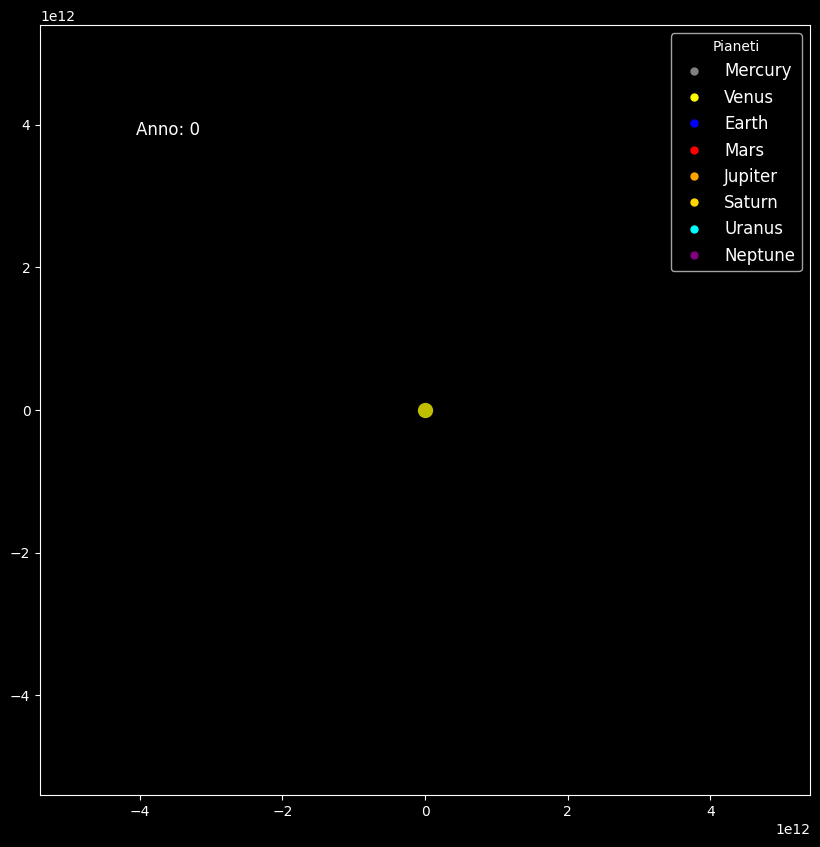

In [14]:
code_version = "15"

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.animation import FFMpegWriter
import matplotlib.lines as mlines
import time

# Costanti fisiche e tempo di simulazione
G = 6.67430e-11                                                 # Costante gravitazionale, m^3 kg^-1 s^-2
AU = 1.496e11                                                   # Unità astronomica in metri
year = 365.25 * 24 * 3600                                       # Anno (giuliano) in secondi
frames_per_year = int(input("Numero frame per anno: "))         # 1 frame per mese -> DA DIMINUIRE PER SIMULAZIONI PIÙ LUNGHE
num_years = int(input("Numero anni: "))                         # Numero di anni di simulazione
total_frames = frames_per_year * num_years * 10                 # Frame totali
time_factor = 1
delta_t = time_factor * year / (frames_per_year*10)                              # Avanzamento temporale per frame
#traj_choice = input("Visualizzare traiettorie? (s/n): ").lower()

print(f"Frames per anno: {frames_per_year}\nAnni: {num_years}")
print(f"Frames totali: {total_frames}\nDelta t: {delta_t/(24*3600):.2e} giorni")

# Dati per i pianeti (nome, massa [kg], distanza iniziale [m], colore)
planets = [
    {"name": "Mercury", "mass": 3.301e23, "distance": 0.387 * AU,   "color": "gray",    "period_y": 0.2408467 * year,   "period_gg": 88.0},
    {"name": "Venus",   "mass": 4.867e24, "distance": 0.723 * AU,   "color": "yellow",  "period_y": 0.61519726 * year,  "period_gg": 224.7},
    {"name": "Earth",   "mass": 5.972e24, "distance": 1 * AU,       "color": "blue",    "period_y": 1.0000174 * year,   "period_gg": 365.2},
    #{"name": "Moon",   "mass": 7.342e22, "distance": 1.00257 * AU, "color": "white",   "period_y": 0.0748 * year,      "period_gg": 27.3},
    {"name": "Mars",    "mass": 6.417e23, "distance": 1.524 * AU,   "color": "red",     "period_y": 1.8808476 * year,   "period_gg": 687.0},
    {"name": "Jupiter", "mass": 1.898e27, "distance": 5.204 * AU,   "color": "orange",  "period_y": 11.862615 * year,   "period_gg": 4_331},
    {"name": "Saturn",  "mass": 5.683e26, "distance": 9.582 * AU,   "color": "gold",    "period_y": 29.447498 * year,   "period_gg": 10_747},
    {"name": "Uranus",  "mass": 8.681e25, "distance": 19.218 * AU,  "color": "cyan",    "period_y": 84.016846 * year,   "period_gg": 30_589},
    {"name": "Neptune", "mass": 1.024e26, "distance": 30.07 * AU,   "color": "purple",  "period_y": 164.79132 * year,   "period_gg": 59_800}
]

# Selezione dei pianeti da visualizzare
selezione = {
    "i": planets[:4],  # Primi 4 pianeti
    "o": planets[4:],  # Ultimi 4 pianeti
    "a": planets       # Tutti i pianeti
}

scelta = input("Inserisci: 'i' per INNER, 'o' per OUTER, 'a' per ALL: ").lower()
my_propagator = input(f"Seleziona il metodo di propagazione (verlet/rk4/leapfrog): ").lower()

if scelta in selezione:
    selected_planets = selezione[scelta]
    num_selected_planets = len(selected_planets)
    print("Pianeti selezionati:")
    for planet in selected_planets:
        print(f"- {planet['name']}")
else:
    print("Scelta non valida. Riprova.")
    
# Gestione file di dati
num_coords = 2
list_data = np.zeros((num_selected_planets, num_coords))
list_filename = []

for i in range(num_selected_planets):
    filename = f"planet_{selected_planets[i]['name'].lower()}_v{code_version}_{my_propagator}_{frames_per_year}fpy_{num_years}y.txt"
    list_filename.append(filename)
print("Lista filename:", list_filename)


# Calcolo della distanza massima per il grafico
max_distance = max([planet["distance"] for planet in selected_planets])
margin = 0.2 * max_distance 

# Corpo centrale (Sole)
sun = {"mass": 1.989e30, "position": np.array([0, 0])}

# Inizializzazione: posizioni, velocità, colori, energie, tempo
positions = []
velocities = []
trajectories = [[] for _ in range(len(selected_planets))]
colors = []
kinetic_energy = []      
potential_energy = []   
mechanical_energy = []  
time_steps = []         


for planet in selected_planets:
    r = np.array([planet["distance"], 0])  # Posizione iniziale
    v_magnitude = np.sqrt(G * sun["mass"] / planet["distance"])  # Velocità orbitale
    v = np.array([0, v_magnitude])  # Velocità perpendicolare a r
    
    #if planet["name"] == "Mercury":
    #    print(f"Mercurio - Velocità calcolata: {v_magnitude:.2e} m/s") # debug
    
    positions.append(r)
    velocities.append(v)
    colors.append(planet["color"])

positions = np.array(positions, dtype=np.float64)
velocities = np.array(velocities, dtype=np.float64)
masses = np.array([p["mass"] for p in selected_planets] + [sun["mass"]])

print("Initial positions shape:", positions.shape)  # Debug
print("Initial positions:", positions)

# Inizializzazione grafico della simulazione
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(10, 10))
year_text = ax.text(-max_distance * 0.9, +max_distance * 0.9, "Anno: 0", fontsize=12, color='white', verticalalignment='top')
ax.set_xlim(-max_distance - margin, max_distance + margin)
ax.set_ylim(-max_distance - margin, max_distance + margin)
ax.set_aspect('equal')

# Inizializzazione punti e linee per ciascun pianeta
planet_plots = []
legend_lines = []
for i in range(len(selected_planets)):
    plot = ax.plot([], [], 'o', color=colors[i], markersize=10)[0]  # Assegna il colore per ciascun pianeta
    planet_plots.append(plot)
    
    legend_line = mlines.Line2D([], [], color=colors[i], marker='o', linestyle='None', markersize=5, label=selected_planets[i]["name"])
    legend_lines.append(legend_line)

ax.legend(handles=legend_lines, loc='upper right', fontsize=12, title="Pianeti")
sun_plot, = ax.plot(0, 0, 'yo', markersize=10) # Disegno del Sole

#print("Planet plots initialized:", planet_plots)  # Debug

## Calcolo accelerazione & Propagatori

In [15]:
# Calcolo accelerazione gravitazionale
def compute_acceleration(positions, masses):
    accelerations = []
    for i, pos_i in enumerate(positions):
        acc = np.zeros(2)
        # Accelerazione gravitazionale Sole-Pianeta
        r_vec_sun = sun["position"] - pos_i 
        r_mag_sun = np.linalg.norm(r_vec_sun)
        if r_mag_sun < 1e8:
            r_mag_sun = 1e8 # Evita divisione per numeri troppo piccoli, debug per Mercurio
        acc += G * sun["mass"] * r_vec_sun / r_mag_sun**3
        
        # Accelerazione gravitazionale Pianeta-Pianeta
        for j, pos_j in enumerate(positions):
            if i != j:  # Evita di calcolare l'accelerazione del pianeta su sé stesso
                r_vec_planet = pos_j - pos_i
                r_mag_planet = np.linalg.norm(r_vec_planet)

                if r_mag_planet < 1e8:
                    r_mag_planet = 1e8  # Evita divisioni per numeri troppo piccoli

                acc += G * masses[j] * r_vec_planet / r_mag_planet**3
        
        accelerations.append(acc)
    return np.array(accelerations)

# Propagatori
def verlet_integration(positions, velocities, masses, dt):
    accelerations = compute_acceleration(positions, masses)
    new_positions = positions + velocities * dt + 0.5 * accelerations * dt**2
    new_accelerations = compute_acceleration(new_positions, masses)
    new_velocities = velocities + 0.5 * (accelerations + new_accelerations) * dt
    return new_positions, new_velocities

def leapfrog_integration(positions, velocities, masses, dt):
    accelerations = compute_acceleration(positions, masses)
    half_step_velocities = velocities + 0.5 * accelerations * dt
    new_positions = positions + half_step_velocities * dt
    new_accelerations = compute_acceleration(new_positions, masses)
    new_velocities = half_step_velocities + 0.5 * new_accelerations * dt
    
    return new_positions, new_velocities

def rk4_integration(positions, velocities, masses, dt):
    def compute_derivatives(pos, vel):
        acc = compute_acceleration(pos, masses)
        return vel, acc
    
    k1_vel, k1_acc = compute_derivatives(positions, velocities)
    k2_vel, k2_acc = compute_derivatives(positions + 0.5 * dt * k1_vel, velocities + 0.5 * dt * k1_acc)
    k3_vel, k3_acc = compute_derivatives(positions + 0.5 * dt * k2_vel, velocities + 0.5 * dt * k2_acc)
    k4_vel, k4_acc = compute_derivatives(positions + dt * k3_vel, velocities + dt * k3_acc)
    
    new_positions = positions + (dt / 6) * (k1_vel + 2 * k2_vel + 2 * k3_vel + k4_vel)
    new_velocities = velocities + (dt / 6) * (k1_acc + 2 * k2_acc + 2 * k3_acc + k4_acc)
    
    return new_positions, new_velocities

def rk4_integration_test(positions, velocities, masses, dt):
    k1_pos, k1_vel = positions, velocities
    k2_pos, k2_vel = positions + 0.5 * dt * k1_vel, velocities + 0.5 * dt * compute_acceleration(k1_pos, masses)
    k3_pos, k3_vel = positions + 0.5 * dt * k2_vel, velocities + 0.5 * dt * compute_acceleration(k2_pos, masses)
    k4_pos, k4_vel = positions + dt * k3_vel, velocities + dt * compute_acceleration(k3_pos, masses)
    
    new_positions = positions + (dt / 6) * (k1_vel + 2 * k2_vel + 2 * k3_vel + k4_vel)
    new_velocities = velocities + (dt / 6) * (k1_pos + 2 * k2_pos + 2 * k3_pos + k4_pos)
    
    return new_positions, new_velocities

#my_propagator = input(f"Seleziona il metodo di propagazione (verlet/rk4/leapfrog): ").lower() -> già inizializzato sopra

## Animazione

In [16]:
simulation_start_time = None
simulation_end_time = None

for frame in range(total_frames):
    global positions, velocities, trajectories, simulation_start_time, planet
    if frame == 0:
        simulation_start_time = time.time()
    
    # Propagazione: posizioni e velocità
    if my_propagator == "verlet":
        positions, velocities = verlet_integration(positions, velocities, masses, delta_t)
    elif my_propagator == "rk4":
        positions, velocities = rk4_integration(positions, velocities, masses, delta_t)
    elif my_propagator == "leapfrog":
        positions, velocities = leapfrog_integration(positions, velocities, masses, delta_t)
        
    # Scrittura delle coordinate nei file
    for i in range(num_selected_planets):
        for j in range(num_coords):
            list_data[i, j] = positions[i, j]
        with open(list_filename[i], 'a') as file:
            file.write(f"{list_data[i, 0]:.2e}\t{list_data[i, 1]:.2e}\n")
        #print("Ho inserito le coordinate di", selected_planets[i]["name"], "nel file", list_filename[i]) # Debug
    
    #print(f"Frame {frame}: positions = {positions}")  # Debug
    
    # Gestione energie
    total_kinetic = 0
    total_potential = 0
    for i, pos_i in enumerate(positions):
        # Energia cinetica
        speed = np.linalg.norm(velocities[i])
        total_kinetic += 0.5 * masses[i] * speed**2
        
        # Energia potenziale con il Sole
        r_sun = np.linalg.norm(pos_i - sun["position"])
        total_potential -= G * masses[i] * sun["mass"] / r_sun
        
        # Energia potenziale con altri pianeti
        for j, pos_j in enumerate(positions):
            if i != j: # Evita doppio conteggio
                r_planet = np.linalg.norm(pos_i - pos_j)
                total_potential -= G * masses[i] * masses[j] / (2 * r_planet)  
    
    kinetic_energy.append(total_kinetic)
    potential_energy.append(total_potential)
    mechanical_energy.append(total_kinetic + total_potential)
    time_steps.append(frame * delta_t / year)  # Tempo in anni
    
    if frame % 50 == 0 and frame != 0:
        print(f"Frame {frame}: Energia cinetica = {total_kinetic:.2e} J, Energia potenziale = {total_potential:.2e} J")  # Debug

"""    
    # Visualizzazione dei pianeti come punti e traiettorie
    for i, plot in enumerate(planet_plots):
        x, y = positions[i, 0], positions[i, 1]
        plot.set_data([x],[y])
        trajectories[i].append([x, y])
        trajectory_x = [pos[0] for pos in trajectories[i]]
        trajectory_y = [pos[1] for pos in trajectories[i]]
        if traj_choice == "s":
            ax.plot(trajectory_x, trajectory_y, color=colors[i], alpha=0.5, linewidth=1) # Disabilita per velocizzare
        else:
            pass
        # alpha = trasparenza, linewidth = spessore
    
    # Testo per l'anno corrente e per il tempo di simulazione
    current_year = frame / (frames_per_year*10)
    year_text.set_text(f"Anno: {current_year:.2f}")
    
    if frame == total_frames - 1:
        global simulation_end_time
        simulation_end_time = time.time()
        elapsed_real_time = simulation_end_time - simulation_start_time
        ax.text(0.65, 0.05, f"Tempo simulazione: {elapsed_real_time:.2f} s", transform=ax.transAxes, fontsize=12, ha='right', va='top', color='white')
        
    sun_plot.set_data([0], [0])
    return planet_plots + [sun_plot] + [year_text]

# Creazione animazione
ani = FuncAnimation(fig, update, frames=total_frames, interval=10, blit=True)
# interval: intervallo di tempo tra i frame in ms
# blit: True per aggiornare solo i punti che cambiano, False per aggiornare tutto
"""

# Nome animazione
if scelta == "i":
    scelta_filename = "inner"
elif scelta == "o":
    scelta_filename = "outer"
elif scelta == "a":
    scelta_filename = "all"
else:
    scelta_filename = "unknown"
basic_filename = "SolSysSim_test" + str(code_version) + "_" + str(my_propagator) + "_"
parameters_filename = scelta_filename + "_" + str(frames_per_year) + "fpy_" + str(num_years) + "y"
output_filename = basic_filename + parameters_filename + ".mp4"


# Salvataggio animazione
#writer = FFMpegWriter(fps=30, metadata={"title": "Solar System Simulation", "artist": "Rick"})
#ani.save(output_filename, writer=writer)
#print(f"Animazione salvata come {output_filename}")
#
#plt.show()


Frame 50: Energia cinetica = 4.58e+35 J, Energia potenziale = -3.89e+35 J
Frame 100: Energia cinetica = 4.59e+35 J, Energia potenziale = -3.90e+35 J
Frame 150: Energia cinetica = 4.59e+35 J, Energia potenziale = -3.90e+35 J
Frame 200: Energia cinetica = 4.72e+35 J, Energia potenziale = -3.84e+35 J
Frame 250: Energia cinetica = 4.72e+35 J, Energia potenziale = -3.84e+35 J
Frame 300: Energia cinetica = 4.72e+35 J, Energia potenziale = -3.84e+35 J
Frame 350: Energia cinetica = 4.73e+35 J, Energia potenziale = -3.85e+35 J
Frame 400: Energia cinetica = 4.72e+35 J, Energia potenziale = -3.84e+35 J
Frame 450: Energia cinetica = 4.72e+35 J, Energia potenziale = -3.84e+35 J
Frame 500: Energia cinetica = 4.72e+35 J, Energia potenziale = -3.84e+35 J
Frame 550: Energia cinetica = 4.72e+35 J, Energia potenziale = -3.84e+35 J
Frame 600: Energia cinetica = 4.73e+35 J, Energia potenziale = -3.84e+35 J
Frame 650: Energia cinetica = 4.72e+35 J, Energia potenziale = -3.84e+35 J
Frame 700: Energia cinetic

In [17]:
print("Lista file txt creati:",list_filename)
print("Parametri:", parameters_filename)
print("Propagatore:", my_propagator)
print("Code version:", code_version)
print("Numero frame:", total_frames)
print("Nome MP4:", output_filename)

Lista file txt creati: ['planet_mercury_v15_rk4_6fpy_50y.txt', 'planet_venus_v15_rk4_6fpy_50y.txt', 'planet_earth_v15_rk4_6fpy_50y.txt', 'planet_mars_v15_rk4_6fpy_50y.txt', 'planet_jupiter_v15_rk4_6fpy_50y.txt', 'planet_saturn_v15_rk4_6fpy_50y.txt', 'planet_uranus_v15_rk4_6fpy_50y.txt', 'planet_neptune_v15_rk4_6fpy_50y.txt']
Parametri: all_6fpy_50y
Propagatore: rk4
Code version: 15
Numero frame: 3000
Nome MP4: SolSysSim_test15_rk4_all_6fpy_50y.mp4


## Grafici Energia

Grafico energia salvato come SolSysSim_test15_rk4_all_6fpy_50y_AllEnergy_15.png
Grafico energia cinetica salvato come energia_cinetica_rk4_all_6fpy_50y_v15.png
Grafico energia potenziale salvato come energia_potenziale_rk4_all_6fpy_50y_v15.png
Grafico energia meccanica salvato come energia_meccanica_rk4_all_6fpy_50y_v15.png


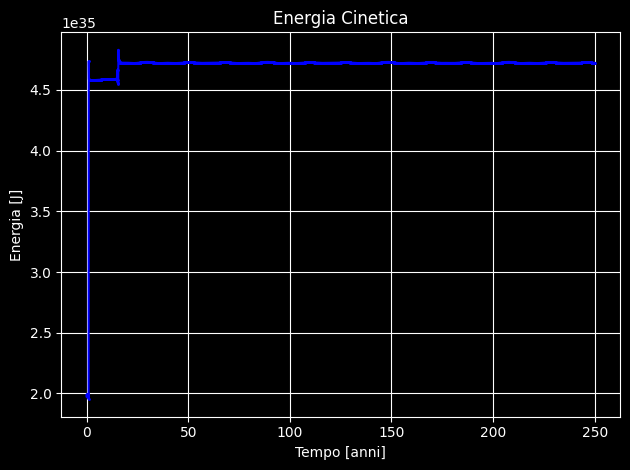

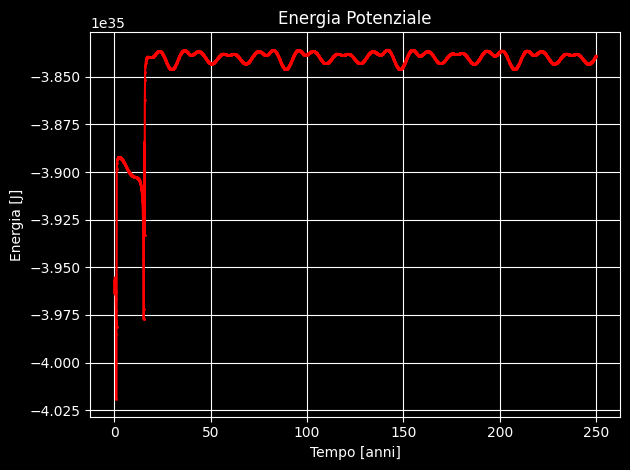

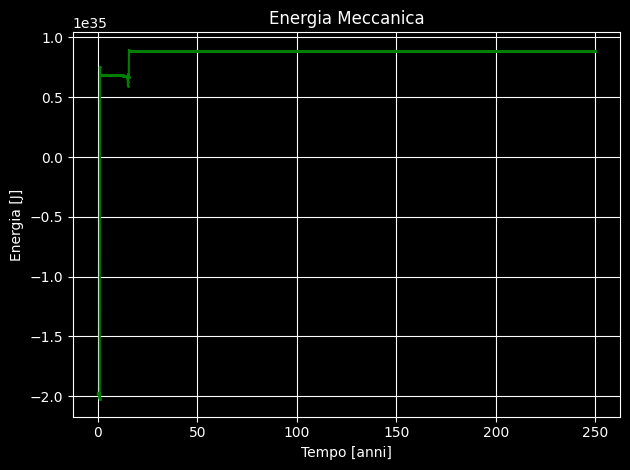

In [18]:
# Tutti i grafici insieme
#scelta = input("Salva grafico generale? (s/n): ").strip().lower()
#if scelta == "s":
plt.figure(figsize=(12, 6))
plt.plot(time_steps, kinetic_energy, label="Energia cinetica", color="cyan")
plt.plot(time_steps, potential_energy, label="Energia potenziale", color="magenta")
plt.plot(time_steps, mechanical_energy, label="Energia meccanica", color="yellow")
plt.xlabel("Tempo [anni]")
plt.ylabel("Energia [J]")
plt.title("Energia del sistema")
plt.legend()
plt.grid()
plt.savefig(basic_filename + parameters_filename + "_AllEnergy_" + code_version + ".png")
print(f"Grafico energia salvato come {basic_filename + parameters_filename}_AllEnergy_{code_version}.png")
plt.close()

scelta_singoli_colorati = input("Salva grafici singoli colorati? (s/n): ").strip().lower()
if scelta_singoli_colorati == "s":
    # Grafico singolo: Energia Cinetica
    plt.figure()
    plt.plot(time_steps, kinetic_energy, label="Energia Cinetica", color="blue", marker="o", linestyle="-", markersize=1)
    plt.xlabel("Tempo [anni]")
    plt.ylabel("Energia [J]")
    plt.title("Energia Cinetica")
    plt.grid(True)
    plt.tight_layout()
    plt.ticklabel_format(useOffset=False) # rimuove ottimizzazione asse y
    plt.savefig("energia_cinetica_" + str(my_propagator) + "_" + parameters_filename + "_v" + code_version + ".png")
    print(f"Grafico energia cinetica salvato come energia_cinetica_{str(my_propagator)}_{parameters_filename}_v{code_version}.png")

    # Grafico singolo: Energia Potenziale
    plt.figure()
    plt.plot(time_steps, potential_energy, label="Energia Potenziale", color="red", marker="o", linestyle="-", markersize=1)
    plt.xlabel("Tempo [anni]")
    plt.ylabel("Energia [J]")
    plt.title("Energia Potenziale")
    plt.grid(True)
    plt.tight_layout()
    plt.ticklabel_format(useOffset=False) # rimuove ottimizzazione asse y
    plt.savefig("energia_potenziale_" + str(my_propagator) + "_" + parameters_filename + "_v" + code_version + ".png")
    print(f"Grafico energia potenziale salvato come energia_potenziale_{str(my_propagator)}_{parameters_filename}_v{code_version}.png")

    # Grafico singolo: Energia Meccanica
    plt.figure()
    plt.plot(time_steps, mechanical_energy, label="Energia Meccanica", color="green", marker="o", linestyle="-", markersize=1)
    plt.xlabel("Tempo [anni]")
    plt.ylabel("Energia [J]")
    plt.title("Energia Meccanica")
    plt.grid(True)
    plt.tight_layout()
    plt.ticklabel_format(useOffset=False) # rimuove ottimizzazione asse y
    plt.savefig("energia_meccanica_" + str(my_propagator) + "_" + parameters_filename + "_v" + code_version + ".png")
    print(f"Grafico energia meccanica salvato come energia_meccanica_{str(my_propagator)}_{parameters_filename}_v{code_version}.png")
else:
    def save_energy_plot(time_steps, energy, energy_type, filename):
        plt.figure()
        plt.plot(time_steps, energy, label=f"Energia {energy_type}", marker="o", linestyle="-", markersize=1)
        plt.xlabel("Tempo [anni]")
        plt.ylabel("Energia [J]")
        plt.title(f"Energia {energy_type}")
        plt.grid(True)
        plt.tight_layout() # ottimizza spaziatura
        plt.ticklabel_format(useOffset=False) # rimuove ottimizzazione asse y
        plt.savefig(filename)
        print(f"Grafico energia {energy_type} salvato come {filename}")
        plt.show()
        plt.close()

    save_energy_plot(time_steps, kinetic_energy, "Cinetica", f"energia_cinetica_{my_propagator}_{parameters_filename}_v{code_version}.png")
    save_energy_plot(time_steps, potential_energy, "Potenziale", f"energia_potenziale_{my_propagator}_{parameters_filename}_v{code_version}.png")
    save_energy_plot(time_steps, mechanical_energy, "Meccanica", f"energia_meccanica_{my_propagator}_{parameters_filename}_v{code_version}.png")

plt.show()

### Tempo simulazione VS Tempo esecuzione

In [19]:
"""
sim_time = 10 #y
real_time = 50 #s
time_ratio = real_time/sim_time

st_anni = float(input("Inserisci il numero di anni: "))
rt_minuti = (st_anni*5)/60 #min
print(f"Durata esecuzione: {rt_minuti} min")
print(f"Durata esecuzione: {rt_minuti/60} ore")
"""

'\nsim_time = 10 #y\nreal_time = 50 #s\ntime_ratio = real_time/sim_time\n\nst_anni = float(input("Inserisci il numero di anni: "))\nrt_minuti = (st_anni*5)/60 #min\nprint(f"Durata esecuzione: {rt_minuti} min")\nprint(f"Durata esecuzione: {rt_minuti/60} ore")\n'